In [118]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf

base_dir = "/cbscratch/franco/datasets"
gtffile = os.path.join(base_dir, "gtex/gencode.v19.annotation.gtf.gz")
gene_info = readgtf.gencode_v12(gtffile, trim=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import pandas as pd
TF_file = "../TFs_Lambert_2018.csv"
TFs = pd.read_csv(TF_file, header = 0)
TrueTFs = list(TFs[ TFs["isTF?"] == "Yes" ].ID)

In [120]:
TF_annot = [x for x in gene_info if x.ensembl_id in TrueTFs]

In [121]:
## Generate annotation file for future analysis
with open("../TF_annotation.txt", 'w') as outstream:
    outstream.write("ensembl_id\tchrom\tstart\tend\tname\n")
    for e in TF_annot:
        outstream.write("\t".join([e.ensembl_id, str(e.chrom), str(e.start), str(e.end), e.name])+"\n")

In [5]:
import collections
TF_dict = collections.defaultdict(dict)
for g in TF_annot:
    TF_dict[g.chrom][g.ensembl_id] = g.start

In [6]:
def search_TF(TF_dict, chrom, pos):
    TSS_distance = 1e10
    cisTF = None
    found = False
    for TF in TF_dict[chrom].keys():
        dist = pos - TF_dict[chrom][TF]
        if np.abs(dist) < TSS_distance:
            TSS_distance = dist
            cisTF = TF
            found = True
    if not found:
        print(chrom, pos)
    return TSS_distance, cisTF

search_TF(TF_dict, 1, 3000000)

(14269, 'ENSG00000142611')

In [7]:
import mpmath

mpmath.mp.dps = 500
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'TFdist', 'TFname']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
       
        
def tejaas(filepath, chrom):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pval( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, TFdist=None, TFname=None))
    return res

In [128]:
# chrms = [6, 7, 8]
chrms = np.arange(1,23)
snp_res_dict = collections.defaultdict(dict)
snp_res_dict_top = collections.defaultdict(dict)
tissues = ["gtex-ms"]
expressions = ["norm"] #"lmcorrected_age_precorr", 
methods = ["tejaas"]
LD = True
isworst = True
for expr in expressions:
    for tissue in tissues:
        snp_res_dict[tissue][expr] = collections.defaultdict(dict)
        snp_res_dict_top[tissue][expr] = collections.defaultdict(dict)
        for method in methods:
            snp_res = list()
            snp_res_top = list()
            print(tissue, method, end=" ")
            for chrom in chrms:
                print(chrom, end=" ")
                inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+expr+"/"+tissue+"/"+method+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
                snp_res += tejaas(inputfile, chrom)
                
                if LD:
                    if isworst:
                        inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+expr+"/"+tissue+"/"+method+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld.worst"
                    else:
                        inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+expr+"/"+tissue+"/"+method+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld"
                else:
                    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+expr+"/"+tissue+"/"+method+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000"
                snp_res_top += tejaas(inputfile, chrom)
            print("")
            snp_res_dict[tissue][expr][method] = snp_res
            snp_res_dict_top[tissue][expr][method] = snp_res_top

gtex-ms tejaas 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 


In [129]:
from operator import attrgetter

def get_all_distances(snplist, TF_dict, nsnps = 10000):
    snp_objects = list()
    ixs = np.random.randint(0, len(snplist), nsnps)
    for i in ixs:
        snp = snplist[i]
        dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
        newsnp = snp._replace(TFdist = dist, TFname=tf)
        snp_objects.append(newsnp)
    return snp_objects

def get_positive_set(snplist, TF_dict, cutoff = -np.log10(0.01), nsnps = 1000, window=2e6):
    sorted_list = sorted(snplist, key=attrgetter('logp'), reverse=True)
    
    counter = 0
    snp_objects = list()
    for snp in sorted_list:
        if snp.logp > cutoff:
            dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
            newsnp = snp._replace(TFdist = dist, TFname=tf)
            snp_objects.append(newsnp)
            counter += 1
            if counter >= nsnps:
                break
    snp_objects_dist = [x for x in snp_objects if np.abs(x.TFdist) <= window]
    print("selected {:d}/{:d} snps, cutoff: {:g}".format(len(snp_objects_dist), len(snp_objects),snp_objects_dist[-1].logp))
    return snp_objects_dist

def get_negative_set(snplist, TF_dict, cutoff = -np.log10(0.5), nsnps = 1000, window=2e6):
    snp_objects = list()
    bad_counter = 0
    # sample some indices (x5 nsnps)
    ixs = np.random.randint(0, len(snplist), nsnps*5)
    for ix in ixs:
        snp = snplist[ix]
        if snp.logp < cutoff:
            dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
            newsnp = snp._replace(TFdist = dist, TFname=tf)
            snp_objects.append(newsnp)
            bad_counter += 1
            if bad_counter >= nsnps:
                break
    snp_objects_dist = [x for x in snp_objects if np.abs(x.TFdist) <= window]
    return snp_objects_dist

def write_snps(snplist, outfile):
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    with open(outfile, 'w') as outstream:
        outstream.write("\t".join(["rsid","chrom", "pos", "-logp", "TFdist", "TFname"]) + "\n")
        for snp in snplist:
            outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:d}\t{:s}\n".format(snp.rsid, snp.chrom, snp.pos, snp.logp, snp.TFdist, snp.TFname))

def read_snps(infile):
    res = list()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            rsid, chrom, pos, logp, TFdist, TFname = line.rstrip().split()
            res.append(SNPRes(rsid=rsid, chrom=int(chrom), pos=int(pos), logp=float(logp), TFdist=int(TFdist), TFname=TFname))
    return res
        

In [130]:
nsnps = 1000
window = 1e6
Numbins = 50
mymethod = "tejaas"
myexpr   = "norm" # "lmcorrected_age_precorr" #
mytissue = "gtex-ms"
outdir   = "/cbscratch/franco/trans-eqtl/analysis/TFvalidation"
if LD:
    paramline = "{:d}_{:s}Mb_LDremoved".format(nsnps, str(int(window/1e6)))
    if isworst:
        paramline += "_worst"
else:
    paramline = "{:d}_{:s}Mb".format(nsnps, str(int(window/1e6)))

# allsnps, allpvals = get_all_distances(snp_res_dict[myexpr][mymethod], TF_dict, nsnps = nsnps)

## Sample real data pvalues
GWSsnps = get_positive_set(snp_res_dict_top[mytissue][myexpr][mymethod], TF_dict, nsnps = nsnps, window = window)
outfile = os.path.join(outdir, myexpr, mytissue, mymethod +"."+paramline+".snps")
write_snps(GWSsnps, outfile)

selected 513/1000 snps, cutoff: 18.205


In [131]:
## Sample real data bad pvalues
# We don't need to save these values, do we?
Ncounts = np.array([])
Nbins = np.array([])
for n in range(100):
    print(n, end=" ")
    negative_snplist = get_negative_set(snp_res_dict[mytissue][myexpr][mymethod], TF_dict, nsnps = nsnps, window = window)
    badsnps = [snp.TFdist for snp in negative_snplist]
    (n, bins) = np.histogram(badsnps, bins=Numbins)
    if Ncounts.shape[0] == 0:
        Ncounts = n
        Nbins = bins
    else:
        Ncounts = np.vstack((Ncounts,n))
        Nbins = np.vstack((Nbins, bins))
        
avgNcounts = np.mean(Ncounts, axis=0)
stdNcounts = np.std(Ncounts, axis=0)
avgNbins   = np.mean(Nbins, axis=0)
width = avgNbins[1] - avgNbins[0]
x = avgNbins[:-1] + width/2

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [132]:

# Sample random data best pvalues
# We have to read the data and process it on the fly, no need to store all randomizations in memory

myrandmethod = "tejaas_rand"
for r in range(1,45):
    randmethod = myrandmethod +"_"+str(r)
    chrms = np.arange(1,23)
    snp_res = list()
    print(randmethod, ":", end=" ")
    for chrom in chrms:
        print(chrom, end=" ")
        if LD:
            if isworst:
                inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld.worst"
            else:
                inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld"
        else:
            inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000"
        snp_res += tejaas(inputfile, chrom)
    
    Rsnps_list = get_positive_set(snp_res, TF_dict, nsnps = nsnps, window = window)
    outfile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
    write_snps(Rsnps_list, outfile)

import time
time.sleep(2)
    
RgwsNcounts = np.array([])
RgwsNbins = np.array([])
for r in range(1,45):
    randmethod = myrandmethod +"_"+str(r)
    infile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
    print("reading ", infile)
    snplist = read_snps(infile)
    Rsig_snps = np.array([snp.TFdist for snp in snplist])
    (n, bins) = np.histogram(Rsig_snps, bins=Numbins)
    if RgwsNcounts.shape[0] == 0:
        RgwsNcounts = n
        RgwsNbins = bins
    else:
        RgwsNcounts = np.vstack((RgwsNcounts,n))
        RgwsNbins = np.vstack((RgwsNbins, bins))
RgwsavgNcounts = np.mean(RgwsNcounts, axis=0)
RgwsstdNcounts = np.std(RgwsNcounts, axis=0)
RgwsavgNbins   = np.mean(RgwsNbins, axis=0)
Rgwswidth = RgwsavgNbins[1] - RgwsavgNbins[0]
Rgwsx = RgwsavgNbins[:-1] + Rgwswidth/2

tejaas_rand_1 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 510/1000 snps, cutoff: 3.01008
tejaas_rand_2 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 504/1000 snps, cutoff: 3.00303
tejaas_rand_3 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 496/1000 snps, cutoff: 2.98759
tejaas_rand_4 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 492/1000 snps, cutoff: 2.99375
tejaas_rand_5 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 506/1000 snps, cutoff: 2.9998
tejaas_rand_6 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 492/1000 snps, cutoff: 2.97064
tejaas_rand_7 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 543/1000 snps, cutoff: 3.00107
tejaas_rand_8 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 522/1000 snps, cutoff: 2.96672
tejaas_rand_9 : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 selected 535/1000 snps, 

StopIteration: 

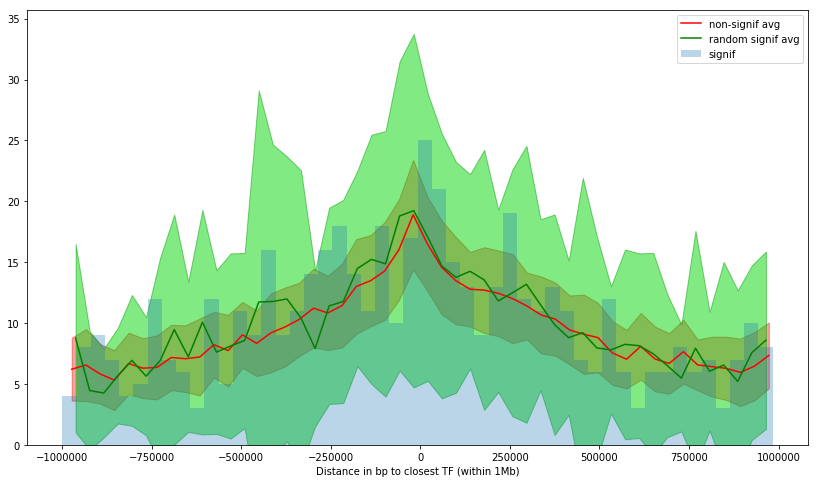

In [113]:
outfile = "../plots/TF_distance_smooth_"+myexpr+"_"+mymethod+"_n"+paramline+".png"

fig = plt.figure(figsize=(14,8))
ax  = fig.add_subplot(111)
GWSdists = [x.TFdist for x in GWSsnps]
ax.hist(GWSdists, bins=Numbins, alpha=0.3, label="signif")

ax.plot(x, avgNcounts, label="non-signif avg", color='red')
ax.fill_between(x, avgNcounts-stdNcounts, avgNcounts+stdNcounts, alpha=0.5, edgecolor='#e51d1d', facecolor='#ff4848')

ax.plot(Rgwsx, RgwsavgNcounts, label="random signif avg", color="green")
ax.fill_between(Rgwsx, RgwsavgNcounts-RgwsstdNcounts, RgwsavgNcounts+RgwsstdNcounts, alpha=0.5, edgecolor='#06a008', facecolor='#04d607')

ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlabel("Distance in bp to closest TF (within 1Mb)")
plt.savefig(outfile, bbox_inches='tight')
plt.show()


selected 513/1000 snps, cutoff: 18.205
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_1.1000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_2.1000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_3.1000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_4.1000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_5.1000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_6

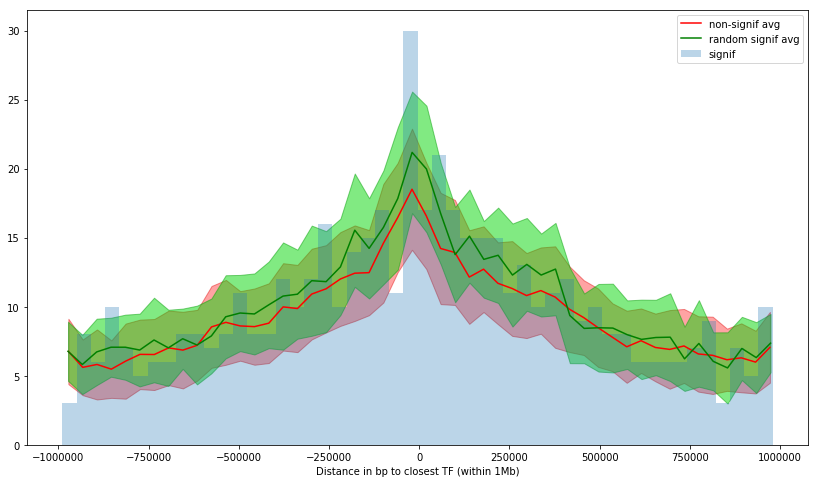

selected 723/1000 snps, cutoff: 18.205
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_1.1000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_2.1000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_3.1000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_4.1000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_5.1000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_6

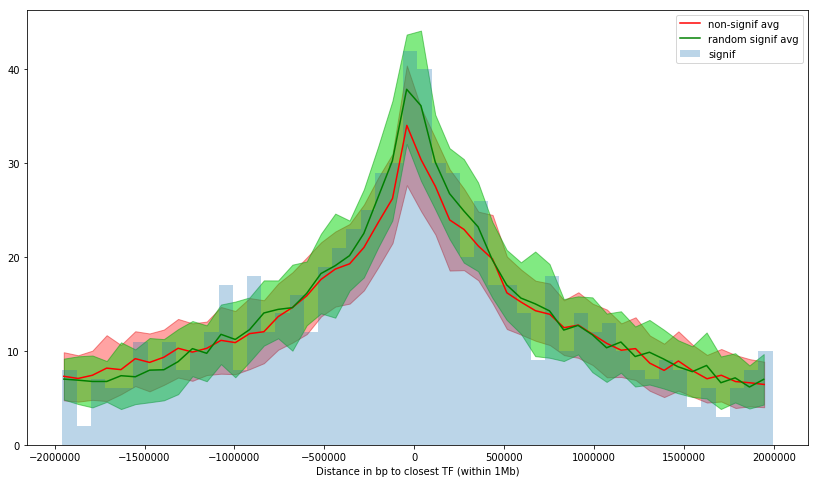

selected 1013/2000 snps, cutoff: 15.3525
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_1.2000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_2.2000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_3.2000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_4.2000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_5.2000_1Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand

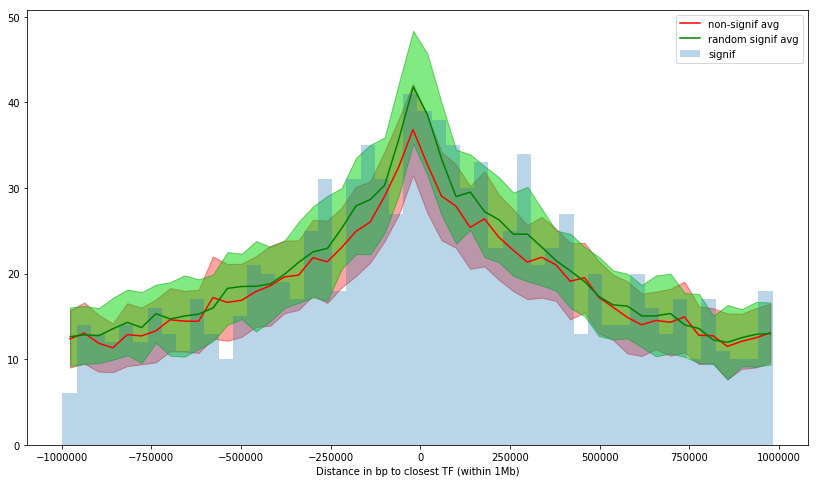

selected 1444/2000 snps, cutoff: 15.3525
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_1.2000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_2.2000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_3.2000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_4.2000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand_5.2000_2Mb_LDremoved_worst.snps
reading  /cbscratch/franco/trans-eqtl/analysis/TFvalidation/norm/gtex-ms/tejaas_rand

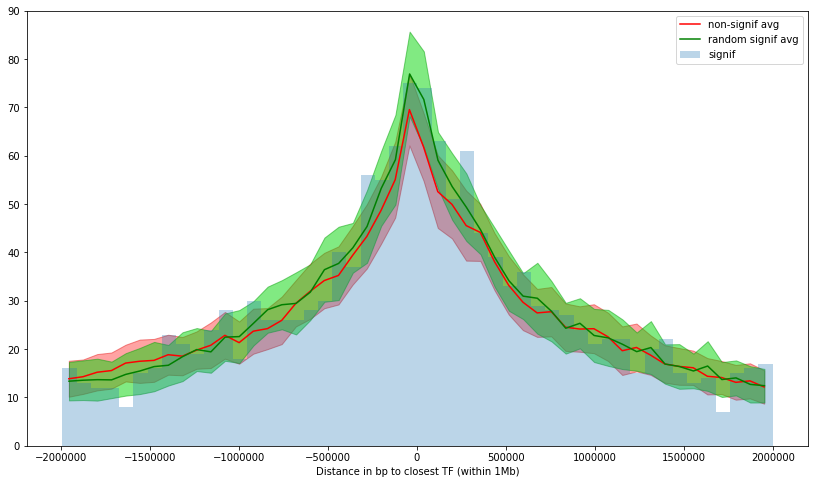

In [133]:
Nsnps = [1000, 2000]
windows = [1e6, 2e6]
Numbins = 50
mymethod = "tejaas"
myexpr   = "norm" # "lmcorrected_age_precorr" #
mytissue = "gtex-ms"
outdir   = "/cbscratch/franco/trans-eqtl/analysis/TFvalidation"
isworst = True

for nsnps in Nsnps:
    for window in windows:
        
        if LD:
            paramline = "{:d}_{:s}Mb_LDremoved".format(nsnps, str(int(window/1e6)))
            if isworst:
                paramline += "_worst"
        else:
            paramline = "{:d}_{:s}Mb".format(nsnps, str(int(window/1e6)))
        # allsnps, allpvals = get_all_distances(snp_res_dict[myexpr][mymethod], TF_dict, nsnps = nsnps)

        ## Sample real data pvalues
        GWSsnps = get_positive_set(snp_res_dict_top[mytissue][myexpr][mymethod], TF_dict, nsnps = nsnps, window = window)
        outfile = os.path.join(outdir, myexpr, mytissue, mymethod +"."+paramline+".snps")
        write_snps(GWSsnps, outfile)

        ######################################################################

        ## Sample real data bad pvalues
        # We don't need to save these values, do we?
        Ncounts = np.array([])
        Nbins = np.array([])
        for n in range(100):
            print(n, end=" ")
            negative_snplist = get_negative_set(snp_res_dict[mytissue][myexpr][mymethod], TF_dict, nsnps = nsnps, window = window)
            badsnps = [snp.TFdist for snp in negative_snplist]
            (n, bins) = np.histogram(badsnps, bins=Numbins)
            if Ncounts.shape[0] == 0:
                Ncounts = n
                Nbins = bins
            else:
                Ncounts = np.vstack((Ncounts,n))
                Nbins = np.vstack((Nbins, bins))

        avgNcounts = np.mean(Ncounts, axis=0)
        stdNcounts = np.std(Ncounts, axis=0)
        avgNbins   = np.mean(Nbins, axis=0)
        width = avgNbins[1] - avgNbins[0]
        x = avgNbins[:-1] + width/2

        ######################################################################

        # Sample random data best pvalues
        # We have to read the data and process it on the fly, no need to store all randomizations in memory

        myrandmethod = "tejaas_rand"
#         for r in range(1,45):
#             randmethod = myrandmethod +"_"+str(r)
#             chrms = np.arange(1,23)
#             snp_res = list()
#             print(randmethod, ":", end=" ")
#             for chrom in chrms:
#                 print(chrom, end=" ")
#                 if LD:
#                     if isworst:
#                         inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld.worst"
#                     else:
#                         inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000.ld"
#                 else:
#                     inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/precorr/"+myexpr+"/gtex-ms/"+randmethod+"/permnull_sb0.05/chr"+str(chrom)+"/rr.txt.top2000"               
#                 snp_res += tejaas(inputfile, chrom)

#             Rsnps_list = get_positive_set(snp_res, TF_dict, nsnps = nsnps, window = window)
#             outfile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
#             write_snps(Rsnps_list, outfile)

#         import time
#         time.sleep(2)

        RgwsNcounts = np.array([])
        RgwsNbins = np.array([])
        for r in range(1,45):
            randmethod = myrandmethod +"_"+str(r)
            infile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
            print("reading ", infile)
            snplist = read_snps(infile)
            Rsig_snps = np.array([snp.TFdist for snp in snplist])
            (n, bins) = np.histogram(Rsig_snps, bins=Numbins)
            if RgwsNcounts.shape[0] == 0:
                RgwsNcounts = n
                RgwsNbins = bins
            else:
                RgwsNcounts = np.vstack((RgwsNcounts,n))
                RgwsNbins = np.vstack((RgwsNbins, bins))
        RgwsavgNcounts = np.mean(RgwsNcounts, axis=0)
        RgwsstdNcounts = np.std(RgwsNcounts, axis=0)
        RgwsavgNbins   = np.mean(RgwsNbins, axis=0)
        Rgwswidth = RgwsavgNbins[1] - RgwsavgNbins[0]
        Rgwsx = RgwsavgNbins[:-1] + Rgwswidth/2

        ######################################################################

        outfile = "../plots/TF_distance_smooth_"+myexpr+"_"+mymethod+"_n"+paramline+".png"

        fig = plt.figure(figsize=(14,8))
        ax  = fig.add_subplot(111)
        GWSdists = [x.TFdist for x in GWSsnps]
        ax.hist(GWSdists, bins=Numbins, alpha=0.3, label="signif")

        ax.plot(x, avgNcounts, label="non-signif avg", color='red')
        ax.fill_between(x, avgNcounts-stdNcounts, avgNcounts+stdNcounts, alpha=0.5, edgecolor='#e51d1d', facecolor='#ff4848')

        ax.plot(Rgwsx, RgwsavgNcounts, label="random signif avg", color="green")
        ax.fill_between(Rgwsx, RgwsavgNcounts-RgwsstdNcounts, RgwsavgNcounts+RgwsstdNcounts, alpha=0.5, edgecolor='#06a008', facecolor='#04d607')

        ax.legend()
        ax.set_ylim(bottom=0)
        ax.set_xlabel("Distance in bp to closest TF (within 1Mb)")
        plt.savefig(outfile, bbox_inches='tight')
        plt.show()
